# SOAM Quickstart
How to make an end to end project using SOAM modules and tools.

![soam_pipeline](documentation/images/SoaM_diagram.png)


This library pipeline supports any data source.
The process is structured in different stages:
* Extraction: manages the connection with the database, the time granularity and the aggregation level of the input data.
* Preprocessing: lets select among out of the box tools to perform standard tasks as normalization or fill nan values.
* Forecasting: fits a model and predict results.
* Postprocessing: modifies the results based on business/real information or create analysis with the predicted values.
* Plotting and Reporting: generates plots and automates reports such as sending a mail or a message to a slack group.


## Extraction
This stage extracts data from the needed sources to build the condensed dataset for the next steps. This tends to be project dependent.

### Establish the connection with the database

In [16]:
from soam.workflow.time_series_extractor import TimeSeriesExtractor
from muttlib.dbconn import get_client

Postgres config set up

In [17]:
pg_cfg = {
    "host": "localhost",
    "port": 5432,
    "db_type": "postgres",
    "username": "mutt",
    "password": "mutt",
    "database": "sqlalchemy"
}

In [18]:
pg_client = get_client(pg_cfg)[1]

In [19]:
extractor = TimeSeriesExtractor(db=pg_client, table_name='stocks_valuation')

#### Then it converts the full dataset to the desired time granularity and aggregation level by some categorical attribute/s and return it as a pandas data frame.
In this case we define the following: <br>
- Time granularity: <br>
     - Start date: 2021-03-01 <br>
     - End date: 2021-03-20
- Aggregation Level:
    - Order the date ascendantly.
    - Just stay with Apple's (AAPL) stock information.

In [20]:
build_query_kwargs={
    'columns': '*',
    'timestamp_col': 'date',
    'start_date': "2021-03-01",
    'end_date': "2021-03-20",
    'extra_where_conditions': ["symbol = 'AAPL'"],
    'order_by': ["date ASC"]
}

Store the query into a <b>pandas dataframe</b> to facilitate data manipulation.

In [21]:
import pandas as pd
df = extractor.run(build_query_kwargs = build_query_kwargs)

df.head()

,index,date,symbol,avg_num_trades,avg_price
0,13,2021-03-01,AAPL,80769.369444,125.3600
1,12,2021-03-02,AAPL,71014.545139,126.8650
2,11,2021-03-03,AAPL,78448.847222,123.7750
3,10,2021-03-04,AAPL,123718.732639,121.1100
4,9,2021-03-05,AAPL,106782.361806,119.7525


## Preprocessing

In [22]:
from soam.workflow import Transformer

Import the MinMaxScaler from Scikit-Learn

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

Create the Transformer object and pass the scaler as the transformer parameter.

In [24]:
ts = Transformer(transformer = scaler)

We want to normalize the average price values.

We convert the column to an array and swap the axes to pass it to the scaler.

In [25]:
import numpy as np
data = np.array([df.avg_price])
data = np.swapaxes(data, 0, 1)

Run the soam transform object and change the values of avg_price for the scaled ones.

In [26]:
df.avg_price = ts.run(data)[0]
df.head()

,index,date,symbol,avg_num_trades,avg_price
0,13,2021-03-01,AAPL,80769.369444,0.817797
1,12,2021-03-02,AAPL,71014.545139,1.000000
2,11,2021-03-03,AAPL,78448.847222,0.625908
3,10,2021-03-04,AAPL,123718.732639,0.303269
4,9,2021-03-05,AAPL,106782.361806,0.138923


We drop the unnecesary columns and adapt the column names for the Fb Prophet for the Forecasting.



We need a `ds` column of type DateTime to indicate the moment of observation in the time series and a `y` column for it's value.



In [27]:
df = df[['date', 'avg_price']]
df.rename(columns = {
    'date': 'ds',
    'avg_price': 'y'}, inplace = True)
df.ds =  pd.to_datetime(df.ds, infer_datetime_format=True)
df.head()

,ds,y
0,2021-03-01,0.817797
1,2021-03-02,1.000000
2,2021-03-03,0.625908
3,2021-03-04,0.303269
4,2021-03-05,0.138923


## Forecasting
Now we have to create a model, for this we use `SoaM Wrappers`.

In this example we will use the fbprophet model.

In [28]:
from soam.workflow.forecaster import Forecaster
from soam.models import SkProphet

In [29]:
my_model = SkProphet(weekly_seasonality=False, daily_seasonality=False)

Then we create a `Forecaster` and pass the Darts model to the constructor. 

In [30]:
forecaster = Forecaster(my_model, output_length=7)

Now we use the `run` method of the forecaster instance that we just created to fit the model to the data and make a prediction.  

The `run` method requires as input a Pandas DataFrame with at least a `ds` column of type DateTime to indicate the moment of observation in the time series and a `y` column for it's value.  
[`Multivariate`](https://unit8co.github.io/darts/generated_api/darts.models.forecasting_model.html#darts.models.forecasting_model.MultivariateForecastingModel) models also accept other timeseries appart from the one in the `y` column we just mentioned. 

Note that both prediction and trained model will be initially stored as attributes of the `Forecaster` instance.

The output length parameter is passed to indicate the number of points that we want to predict in the future.

In the `add_future_dates` method, the amount of periods to predict is passed as a parameter as well as the frequency (time granularity) of those periods. In this case we use 7 days.

*Note that some models may fails if output lenght is larger than input lenght.*


In [31]:
from soam.utilities.utils import add_future_dates
df = add_future_dates(df, periods=7, frequency="d")
predictions, time_series, model = forecaster.run(time_series=df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


AttributeError: 'StanModel' object has no attribute 'fit_class'

Note that both prediction and trained model will be initially stored as attributes of the `Forecaster` instance.

In [17]:
dfp = df
dfp["ds"] = dfp["ds"].dt.strftime("%d")
dfp = dfp.set_index("ds")

predp = predictions
predp["ds"] = predp["ds"].dt.strftime("%d")
predp =  predp.set_index("ds")

Now we plot the results to compare the predicted values with the expected ones visually.

/home/scafati98/MUTT/soam/quickstart_env/lib/python3.8/site-packages/matplotlib/cbook.py:2224: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/scafati98/MUTT/soam/quickstart_env/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/scafati98/MUTT/soam/quickstart_env/lib/python3.8/site-packages/matplotlib/axes/_base.py:252: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


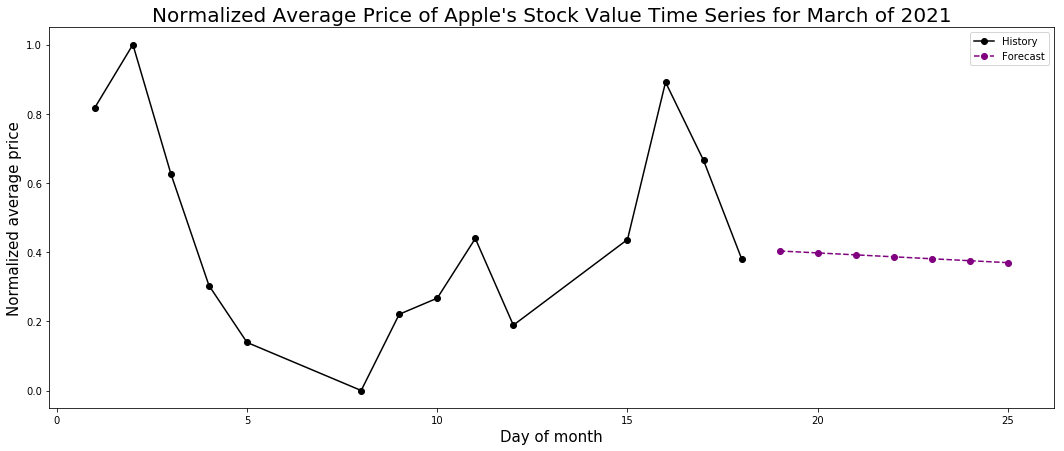

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,7))
plt.plot(dfp.index, dfp.y, marker='o', color='black', label="History")
plt.plot(predp.index, predp.yhat, marker='o', color='purple', linestyle='dashed', label="Forecast")

plt.legend(loc='best')

plt.title("Normalized Average Price of Apple's Stock Value Time Series for March of 2021", fontdict = {'fontsize': '20',
 'fontweight' : '300',
 'verticalalignment': 'baseline'})
plt.ylabel('Normalized average price', fontdict = {'fontsize': '15'})
plt.xlabel('Day of month', fontdict = {'fontsize': '15'})



plt.savefig('img/applestockprice.png')
plt.show()


## Postprocessing

###  Mail Report

The class `MailReport` has everything you need for sending an email report, you'll just need a SMTP enabled email account. 

Your gmail account should have 2FA (Two-Factor Authentication) and Third-Party apps permissions active, with that you'll be able to create an App Pasword for your smtp settings. [Official Gmail guide](https://support.google.com/mail/answer/185833?hl=en)

Make sure to add your SMTP credentials to `settings.ini` *(located in the root file of your project)*. If using a Gmail account, you won't have to modify the `SMTP_HOST` and `SMTP_PORT`.

*Note that you can find a sample of the `settings.ini` file in the following path: soam/soam/templates/init/{{ cookiecutter.package_name }}/{{ cookiecutter.project_name }}/settings_sample.ini*

In [19]:
from soam.reporting import mail_report

In [20]:
mr = mail_report.MailReportTask(
    # recipients mails separated by commas
    mail_recipients_list = ["mail@gmail.com"],
    # the metric name will be in the title
    metric_name = "Stocks Forecast" 
)

In [21]:
mr.run(
    # insert current datetime as string
    current_date = "2021-04-06",
    # relative path of the plot
    plot_filename = "img/applestockprice.png"
)

INFO:soam.reporting.mail_report:Sending email report to: ['mail@gmail.com']
INFO:soam.reporting.mail_report:About to send the following email:
                    'From: ' SoaM Reporter
                    'To: ' ['mail@gmail.com']
                    'Subject: ' [2021-04-06]Forecast report for Stocks Forecast
                    'Using host': smtp.gmail.com and port: 587
ERROR:soam.reporting.mail_report:With the following body: 
 <!DOCTYPE html>

<head>
  <meta charset='UTF-8'>
  <style type='text/css'>
    .maindiv {
      height: 100%;
      width: 100% !important;
      background-color: #f7f7f7;
      margin: 0;
      padding: 0;
      overflow: auto;
    }

    .contentdiv {
      background-size: cover;
      background-color: #ffffff;
      width: 90%;
      margin: 14px auto 0 auto;
      padding: 14px;
    }

    .header {
      font-size: 16px;
      line-height: 22px;
      font-family: 'Open Sans', 'Helvetica Neue', Helvetica, Arial, sans-serif;
      color: #666;
      ba

### Email sent

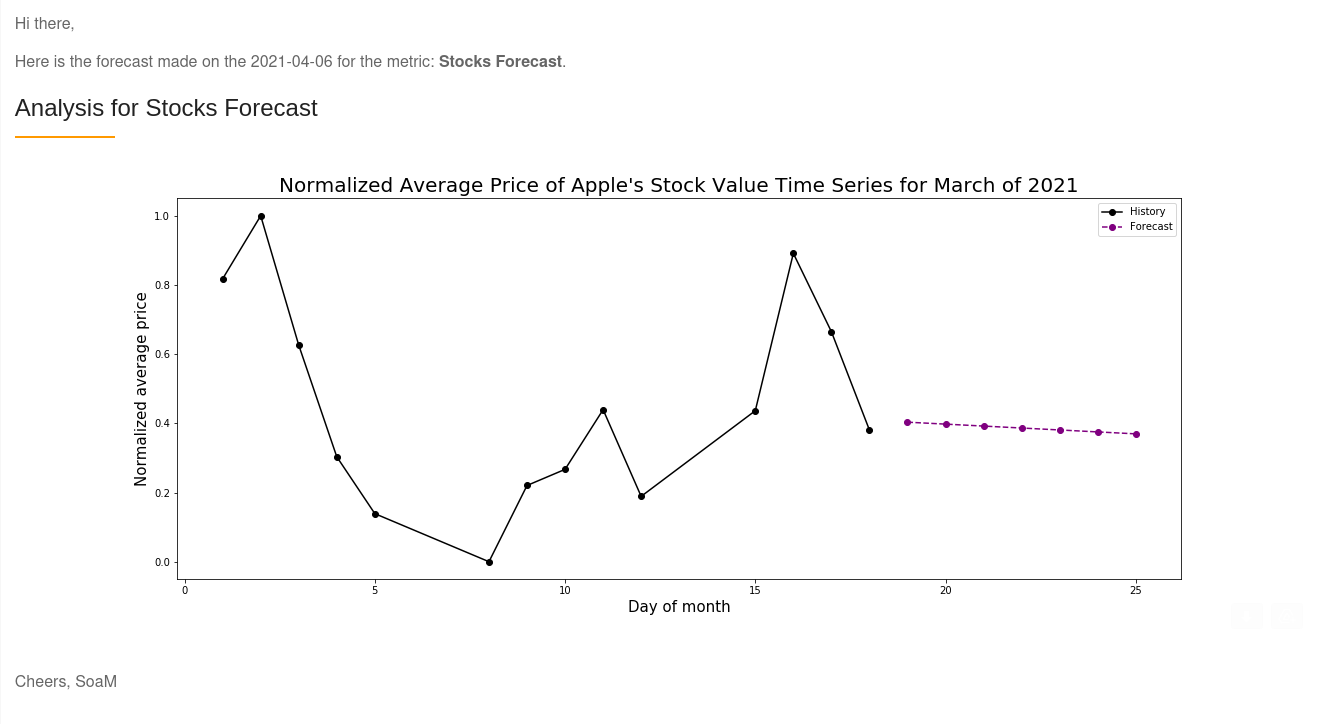

In [22]:
from IPython.display import display, Image

display(Image(filename='img/emailreport_apple.png'))